# Genetic Optimization (GO)

## Quick introduction

<img src="img/go_overview.png">

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import external librarires
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Import our code
from objfun_tsp import TSPGrid

**Let's use the well-known ``TSPGrid(3, 3)`` for demonstration purposes**

In [3]:
tsp = TSPGrid(3, 3)

## GO building blocks demonstration

### 1. Selection

* **Rank based, using exponential distribution**
* Let $U$ be random variable from uniform distribution and $\lambda \in \mathbb{R}$ ($1/\lambda$ will be the *selection temperature*)
* We can **select** $R$-th solution from sorted population as follows:

$$ R = \lceil \frac{-\ln(U)}{\lambda} \rceil $$

In [4]:
# Let us generate 1000 random numbers
u = np.random.uniform(low=0.0, high=1.0, size=1000)

In [5]:
# And the selection function
def demo_select(T):
    return np.ceil(-T*np.log(u))

#### Low temperature -> first (the best one) solution is selected always:

<IPython.core.display.Javascript object>


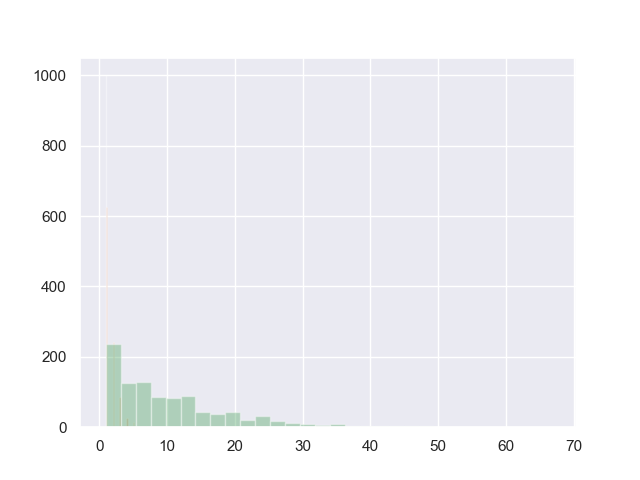

In [6]:
k = demo_select(0.1)
ax = sns.distplot(k, kde=False)

#### Medium temperature

In [7]:
k = demo_select(1)
ax = sns.distplot(k, kde=False)

#### Higher temperature

In [8]:
k = demo_select(10)
ax = sns.distplot(k, kde=False)

Higher temperatures could be much more useful...

### 2. Crossover

There are many possibilities, let's start with **uniform multi point crossover**:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/OnePointCrossover.svg/231px-OnePointCrossover.svg.png">

In [9]:
def crossover(x, y, m):
    m=m+1  # m ... number of crossover points
    n=np.size(x)
    z=x*0
    k=0
    p=np.ceil(n/m).astype(int)
    for i in np.arange(1, m+1):
        ix_from = k
        ix_to = np.minimum(k+p, n)
        z[ix_from:ix_to] = x[ix_from:ix_to] if np.mod(i, 2) == 1 else y[ix_from:ix_to]
        k += p
    return z

In [10]:
c = crossover(
    np.array([1, 1, 1, 1, 1, 1], dtype=int), 
    np.array([0, 0, 0, 0, 0, 0], dtype=int), 
    1)
print(c)

[1 1 1 0 0 0]


In [11]:
c = crossover(
    np.array([1, 1, 1, 1, 1, 1], dtype=int), 
    np.array([0, 0, 0, 0, 0, 0], dtype=int), 
    2)
print(c)

[1 1 0 0 1 1]


In [12]:
c = crossover(
    np.array([1, 1, 1, 1, 1, 1], dtype=int), 
    np.array([0, 0, 0, 0, 0, 0], dtype=int), 
    5)
print(c)

[1 0 1 0 1 0]


### 3. Mutation

We can re-use Cauchy one (for now).

## Run GO and test different population sizes

In [13]:
from heur_go import GeneticOptimization, UniformMultipoint  # you will need to implement this on your own!
from heur_aux import Correction, CauchyMutation

In [14]:
NUM_RUNS = 1000
maxeval = 1000

In [15]:
# traditional testing procedure setup
def experiment_go(of, maxeval, num_runs, N, M, Tsel1, Tsel2, mutation, crossover):
    results = []
    heur_name = 'GO_{}'.format(N)
    for i in tqdm(range(num_runs), 'Testing {}'.format(heur_name)):
        result = GeneticOptimization(of, maxeval, N=N, M=M, Tsel1=Tsel1, Tsel2=Tsel2, 
                                     mutation=mutation, crossover=crossover).search()
        result['run'] = i
        result['heur'] = heur_name
        result['N'] = N
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'N', 'best_x', 'best_y', 'neval'])

In [16]:
results = pd.DataFrame()
mutation = CauchyMutation(r=0.75, correction=Correction(tsp))
crossover = UniformMultipoint(1)
for N in [1, 2, 3, 5, 10, 20, 30, 100]:
    res = experiment_go(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, N=N, M=N*3, Tsel1=1, Tsel2=.1, 
                        mutation=mutation, crossover=crossover)
    results = pd.concat([results, res], axis=0)

In [17]:
# (well-known performance criteria from previous classes)
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)
def mne(x):
    return np.mean([n for n in x if n < np.inf])
def feo(x):
    return mne(x)/rel(x)

In [18]:
results_pivot = results.pivot_table(
    index=['heur', 'N'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot = results_pivot.reset_index()
results_pivot.sort_values(by='N')

,heur,N,feo,mne,rel
0,GO_1,1,414.500710,353.983607,0.854
3,GO_2,2,329.021963,308.622601,0.938
5,GO_3,3,292.491523,284.009269,0.971
7,GO_5,5,259.456764,254.008172,0.979
1,GO_10,10,267.650707,262.832994,0.982
4,GO_20,20,292.542929,279.085954,0.954
6,GO_30,30,318.385746,300.556144,0.944
2,GO_100,100,403.602382,369.699782,0.916


## Assignment

* Finish your own implementation of GO
* Thoroughly analyze effects of other parameters on GO performance
* Make use of a detailed log to verify your assumptions